# Exploratory data analysis for the dataset of the paper

Author: Marco Della Vedova - marco.dellavedova@gmail.com

In [ ]:
%reset
from eda_utils import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Loading two json files of the fb02 dataset: 
# 1) the postid:[userids] dictionary representing likes and 
# 2) the pageid:hoaxflag dictionary
with open('../datasets/likers.json') as data_file:
    datadict = json.load(data_file)
with open('hoaxpagedict.json') as pagedatafile:
    hoaxpagedict = json.load(pagedatafile)

FileNotFoundError: [Errno 2] No such file or directory: '../datasets/likers.json'

In [3]:
# Get hoax pages and non-hoax pages lists from the hoaxpages dict for convenience 
pages_hoax = [pageid for pageid in hoaxpagedict.keys() if hoaxpagedict[pageid]]
pages_nonhoax = [pageid for pageid in hoaxpagedict.keys() if not hoaxpagedict[pageid]]
print("Pages: %d hoax vs. %d non-hoax" % (len(pages_hoax), len(pages_nonhoax)))

# Check integrity
len(set([i.split('_')[0] for i in datadict.keys()])) == (len(pages_nonhoax) + len(pages_hoax))

Pages: 14 hoax vs. 18 non-hoax


True

In [4]:
# Print basic statistics about dataset 
def print_stat(data):
    nposts = len(data)
    nposts_h = len(list(filter(is_hoax, data)))
    
    nusers = get_number_of_users(data)
    likes_hoax, likes_nhoax = split_likes(data)
    hoax_likers = set(likes_hoax)
    nonhoax_likers = set(likes_nhoax)
    both_likers = nonhoax_likers.intersection(hoax_likers)
    nusers_intesection = len(both_likers)
    nusers_hoaxonly = len(hoax_likers) - nusers_intesection
    nusers_nonhoaxonly = len(nonhoax_likers) - nusers_intesection
    
    nlikes = get_number_of_likes(data)
    
    data_post = [len(likes) for _, likes in data.items()]
    
    from collections import Counter
    data_user = list(Counter(likes_hoax+likes_nhoax).values())
    
    print("N. of posts: %d = %d hoax + %d nonhoax" %
          (nposts, nposts_h, nposts-nposts_h))
    print("N. of users: %d = %d hoax-only + %d nonhoax-only + %d intersect" % 
          (nusers, nusers_hoaxonly, nusers_nonhoaxonly, nusers_intesection))
    print("N. of likes: %d = %d hoax + %d nonhoax" % 
          (nlikes, len(likes_hoax), len(likes_nhoax)))
    print("Likes per post: avg. %.1f, median %d, max %d" %
          (np.average(data_post), np.median(data_post), np.max(data_post)))
    print("Likes per user: avg. %.1f, median %d, max %d" %
          (np.average(data_user), np.median(data_user), np.max(data_user)))

In [5]:
# Statistics for all the dataset
print_stat(datadict)

N. of posts: 15500 = 8923 hoax + 6577 nonhoax
N. of users: 909236 = 759368 hoax-only + 135729 nonhoax-only + 14139 intersect
N. of likes: 2376776 = 1824551 hoax + 552225 nonhoax
Likes per post: avg. 153.3, median 19, max 121491
Likes per user: avg. 2.6, median 1, max 1028

In [9]:
datafp = filter_post(datadict, 10)
print_stat(datafp)

N. of posts: 10110 = 6220 hoax + 3890 nonhoax
N. of users: 907937 = 758652 hoax-only + 135225 nonhoax-only + 14060 intersect
N. of likes: 2352824 = 1812733 hoax + 540091 nonhoax
Likes per post: avg. 232.7, median 44, max 121491
Likes per user: avg. 2.6, median 1, max 808

In [5]:
datafu = filter_user(datadict, 1)
print_stat(datafu)

N. of posts: 15500 = 8923 hoax + 6577 nonhoax
N. of users: 909236 = 759368 hoax-only + 135729 nonhoax-only + 14139 intersect
N. of likes: 2376776 = 1824551 hoax + 552225 nonhoax
Likes per post: avg. 153.3, median 19, max 121491
Likes per user: avg. 2.6, median 1, max 1028

In [6]:
# Count user likes split into hoax-likes and nonhoax-likes
def likes_per_user_split_count(data, f=lambda x: True):
    from collections import Counter
    # f = lambda x: x in both_likers
    # u = both_likers
    # f = lambda x: True
    u = list(filter(f, get_user_set(data)))
    likes_hoax, likes_nhoax = split_likes(data)
    likes_hoax_counter = Counter(filter(f, likes_hoax))
    likes_nhoax_counter = Counter(filter(f, likes_nhoax))
    userlikes_split = np.zeros([len(u), 2])
    for i, userid in enumerate(u):
        userlikes_split[i, 0] = likes_hoax_counter[userid]
        userlikes_split[i, 1] = likes_nhoax_counter[userid]
    return userlikes_split
# userlikes_split = splitlikes(datafu)
# userlikes_split

In [7]:
likes_hoax, likes_nhoax = split_likes(datadict)
hoax_likers = set(likes_hoax)
nonhoax_likers = set(likes_nhoax)
both_likers = nonhoax_likers.intersection(hoax_likers)
len(both_likers)

14139

In [8]:
# Matplotlib configuration for better view in latex
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('figure', figsize='4, 3')

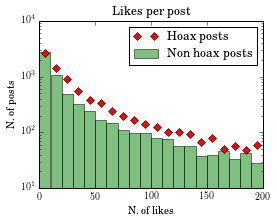

Likes per post (avg.): 204.5 hoax vs 84.0 non-hoax
Likes per post (median): 22.0 hoax vs 14.0 non-hoax
Likes per post (max): 121491 hoax vs 13608 non-hoax


In [43]:
# Histogram of the likes per post distribution
maxlikes = 200
bins = list(range(0,maxlikes+1,10))

hoax_nlikes_f = [len(likes) for post_id, likes in datadict.items() if is_hoax(post_id)]
nhoax_nlikes_f = [len(likes) for post_id, likes in datadict.items() if not is_hoax(post_id)]

#n, _, p1 = plt.hist(list(filter(lambda x: x<=maxlikes, nhoax_nlikes_f)),bins=bins, alpha=0)
n, bin_edges = np.histogram(list(filter(lambda x: x<=maxlikes, hoax_nlikes_f)),bins=bins)
p2 = plt.plot(range(5,maxlikes+1,10),n, marker='D', linestyle='', color='red')
_, _, p3 = plt.hist(list(filter(lambda x: x<=maxlikes, nhoax_nlikes_f)), bins=bins, alpha=0.5, color='green')

plt.xlim([0,maxlikes])
plt.yscale('log')
plt.title("Likes per post")
plt.xlabel("N. of likes")
plt.ylabel("N. of posts")
plt.legend(labels=["Hoax posts", "Non hoax posts"])
plt.savefig("postlikes_hist.pdf")
plt.show()
print("Likes per post (avg.): %.1f hoax vs %.1f non-hoax" % (np.average(hoax_nlikes_f), np.average(nhoax_nlikes_f)))
print("Likes per post (median): %.1f hoax vs %.1f non-hoax" % (np.median(hoax_nlikes_f), np.median(nhoax_nlikes_f)))
print("Likes per post (max): %d hoax vs %d non-hoax" % (np.max(hoax_nlikes_f), np.max(nhoax_nlikes_f)))

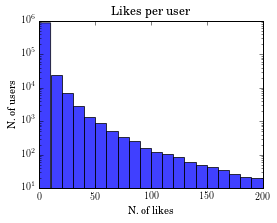

In [9]:
# Histogram of likes per user distribution
maxlikes = 200
minlikes = 0
bins = list(range(minlikes,maxlikes+1,10))
from collections import Counter
user_nlikes = [x for x in Counter(likes_hoax+likes_nhoax).values()]
bothuser_nlikes = [x for x in Counter(filter(lambda x: x in both_likers,
                                             likes_hoax+likes_nhoax)
                                      ).values()]
n, bin_edges = np.histogram(bothuser_nlikes, 
                            bins=bins)
# p2 = plt.plot(range(5,maxlikes+1,10),n, marker='D', linestyle='', color='yellow')

plt.hist(list(filter(lambda x: x<=maxlikes and x>=minlikes, user_nlikes)), bins=bins, alpha=0.75, color='blue')
plt.xlim([minlikes, maxlikes])
plt.yscale('log')
plt.xlabel("N. of likes")
plt.ylabel("N. of users")
plt.title("Likes per user")
# plt.legend(labels=["Intersection dataset", "Complete dataset"])
plt.savefig("userlikes_hist.pdf")
plt.show()

In [36]:
from collections import Counter
data_user = Counter(Counter(likes_hoax+likes_nhoax).values())
print("N. of users with one single like: %d (%.1f%%)" % (data_user[1], 100*data_user[1]/get_number_of_users(datadict)))

N. of users with one single like: 629146 (69.2%)


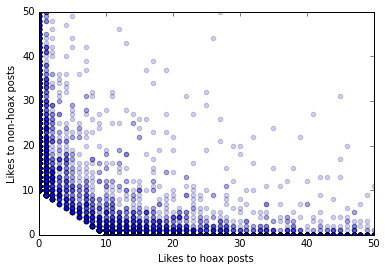

In [16]:
# Scatter plot: hoax likes vs. nonhoax likes
userlikes_split = likes_per_user_split_count(datafu)
minlike = 10
xylim = 50
mask = (userlikes_split[:,0] + userlikes_split[:,1] >= minlike) \
    * (userlikes_split[:,0] <= xylim) \
    * (userlikes_split[:,1] <= xylim)

x = userlikes_split[mask, 0]
y = userlikes_split[mask, 1]
plt.scatter(x, y, alpha=0.2)
plt.xlim([0,xylim])
plt.ylim([0,xylim])
plt.xlabel("Likes to hoax posts")
plt.ylabel("Likes to non-hoax posts")
plt.savefig("bothusers_scatter.pdf")
plt.show()

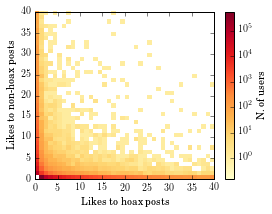

In [39]:
# Heatmap plot: hoax likes vs. nonhoax likes
userlikes_split = likes_per_user_split_count(datafu)
xylim = 40
from matplotlib.colors import LogNorm
x = userlikes_split[:,0]
y = userlikes_split[:,1]
mask = (x <= xylim) * (y <= xylim)
plt.hist2d(x[mask], y[mask], bins=xylim, norm=LogNorm(vmin=0.15))
plt.xlim([0,xylim])
plt.ylim([0,xylim])
plt.xlabel("Likes to hoax posts")
plt.ylabel("Likes to non-hoax posts")
plt.set_cmap("YlOrRd")
#legend
cbar = plt.colorbar()
cbar.set_label('N. of users')
plt.savefig("userlikes_hist2d.pdf")
plt.show()

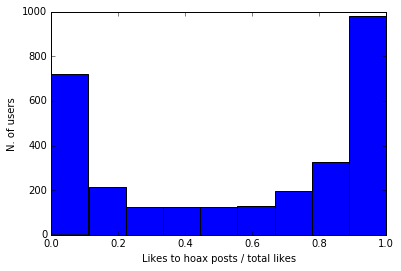

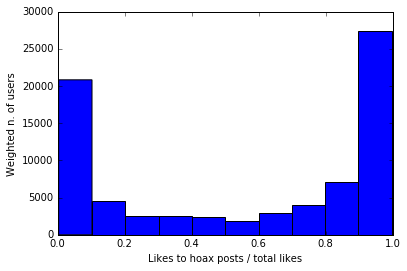

N. of users with p: 0.25<p<=0.75 => 604


In [18]:
# Histogram of hoax likes proportion for intersection users 
userlikes_split = likes_per_user_split_count(datadict, f=lambda x: x in both_likers)
# userlikes_split = likes_per_user_split_count(datadict)
lim = 10  # minimum total number of likes
mask = (userlikes_split[:,0] + userlikes_split[:,1] >= lim)
x = userlikes_split[mask, 0]
y = userlikes_split[mask, 1]
w = x + y
p = x / w
nbins = int(np.log2(len(x)))+2
plt.hist(p, bins=np.linspace(0,1,lim))
plt.xlim([0,1])
plt.xlabel("Likes to hoax posts / total likes")
plt.ylabel("N. of users")
plt.savefig("bothusers_hist.pdf")
plt.show()
plt.hist(p, weights=w, bins=lim)
#plt.yscale('log')
plt.xlabel("Likes to hoax posts / total likes")
plt.ylabel("Weighted n. of users")
plt.savefig("allmixedusers.png")
plt.show()
print("N. of users with p: 0.25<p<=0.75 => %d" % len(p[(p>0.25)*(p<=0.75)]))

In [93]:
%%time
# Create new dict {pageid: list of likers}
pageslikesdict = dict()
for postid, likes in datadict.items():
    pageid = postid.split('_')[0]
    if pageid in pageslikesdict:
        pageslikesdict[pageid] += likes
    else:
        pageslikesdict[pageid] = likes
for pageid, likes in pageslikesdict.items():
    pageslikesdict[pageid] = set(pageslikesdict[pageid])
    # print("%s %d %d" % (pageid, (pageid in pages_hoax), len(likes)))

CPU times: user 240 ms, sys: 0 ns, total: 240 ms
Wall time: 240 ms


In [94]:
%%time
# Likers in common for pages as a dict {(pageid, pageid): # of users in common}
from itertools import combinations, combinations_with_replacement
print(len(list(combinations(pages_hoax+pages_nonhoax, 2))))
commondict = dict()
# for pair in combinations(pages_hoax+pages_nonhoax, 2):
for pair in combinations_with_replacement(pages_hoax+pages_nonhoax, 2):
    commondict[pair] = len( pageslikesdict[pair[0]] & pageslikesdict[pair[1]] )

496
CPU times: user 144 ms, sys: 4 ms, total: 148 ms


Wall time: 148 ms


[[10873     8    95 ...,     5    52     4]
 [    0   335     0 ...,     2     2     0]
 [    0     0  2721 ...,     1     3     2]
 ..., 
 [    0     0     0 ...,   469    84    37]
 [    0     0     0 ...,     0  9347   135]
 [    0     0     0 ...,     0     0   654]]


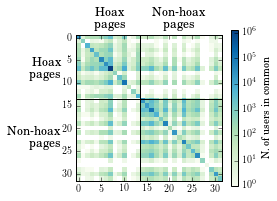

In [132]:
# Plot the likers in common as a matrix and as an image
from matplotlib.colors import LogNorm
M = np.zeros((32,32), dtype=np.int)
pageN = {p: i for i, p in enumerate(pages_hoax+pages_nonhoax)}
for pair, nusers in commondict.items():
    M[pageN[pair[0]], pageN[pair[1]]] = nusers
print(M)
np.savetxt("pagesusers_matrix.csv", M,  delimiter=',')

fig = plt.figure()
plt.imshow(M + np.transpose(M), interpolation='nearest', norm=LogNorm())

plt.axvline(13.6, color='k')
plt.axhline(13.6, color='k')
plt.text(6.8, -2, "Hoax\npages", 
         fontsize=12,
         horizontalalignment='center')
plt.text(22, -2, "Non-hoax\npages", 
         fontsize=12,
         horizontalalignment='center')
plt.text(-4, 6.8, "Hoax\npages", 
         fontsize=12,
         horizontalalignment='right',
         verticalalignment='center')
plt.text(-4, 22, "Non-hoax\npages", 
         fontsize=12,
         horizontalalignment='right',
         verticalalignment='center')

plt.set_cmap("GnBu")
cbar = plt.colorbar()
cbar.set_label('N. of users in common')
fig.subplots_adjust(top=0.85, left=0.27)
fig.savefig("users_pages.pdf")
plt.show()

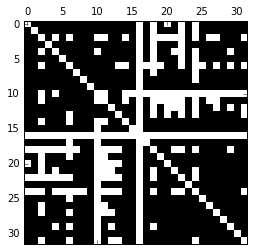

In [12]:
plt.spy(M + np.transpose(M))
plt.show()